In [1]:
import tensorflow.keras as keras
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [2]:
def grab_image(img_path):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(208, 176))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
negative_images = np.concatenate( [grab_image('AlzheimersDataset/Negative/neg(%d).jpg'%(i)) for i in range(1, 3201)])
positive_images = np.concatenate( [grab_image('AlzheimersDataset/Positive/pos(%d).jpg'%(i)) for i in range(1, 3201)])

In [4]:
# images are normalized
negative_images[0][104][60]

array([0.7019608], dtype=float32)

In [5]:
negative_labels = np.zeros(3200, dtype=int)
positive_labels = np.ones(3200, dtype=int)

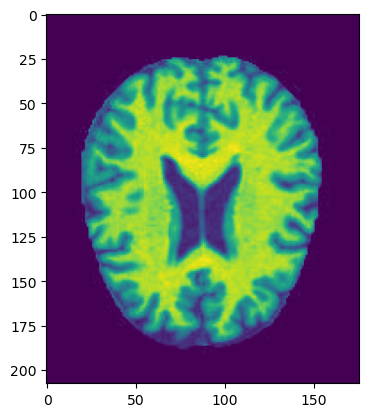

In [6]:
plt.imshow(image.array_to_img(negative_images[0,:,:,:]))
plt.show()

In [7]:
print(negative_images.shape)
print(negative_labels.shape)
print(positive_images.shape)
print(positive_labels.shape)

(3200, 208, 176, 1)
(3200,)
(3200, 208, 176, 1)
(3200,)


In [8]:
X = np.concatenate([negative_images, positive_images])
Y = np.concatenate([negative_labels, positive_labels])

In [9]:
print(X.shape)
print(Y.shape)

(6400, 208, 176, 1)
(6400,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
display(X_train.shape)
display(Y_train.shape)
display(X_test.shape)
display(Y_test.shape)

(5120, 208, 176, 1)

(5120,)

(1280, 208, 176, 1)

(1280,)

In [12]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
batch_size = 32
epochs = 10
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split = 0.2,
                    shuffle=True)

Epoch 1/10
128/128 [==============================] - 60s 464ms/step - loss: 0.6570 - accuracy: 0.6038 - val_loss: 0.5837 - val_accuracy: 0.7109
Epoch 2/10
128/128 [==============================] - 66s 514ms/step - loss: 0.5481 - accuracy: 0.7229 - val_loss: 0.5233 - val_accuracy: 0.7402
Epoch 3/10
128/128 [==============================] - 68s 531ms/step - loss: 0.4519 - accuracy: 0.7798 - val_loss: 0.4040 - val_accuracy: 0.8193
Epoch 4/10
128/128 [==============================] - 65s 511ms/step - loss: 0.3293 - accuracy: 0.8513 - val_loss: 0.2812 - val_accuracy: 0.8770
Epoch 5/10
128/128 [==============================] - 66s 518ms/step - loss: 0.2064 - accuracy: 0.9141 - val_loss: 0.2996 - val_accuracy: 0.8789
Epoch 6/10
128/128 [==============================] - 66s 515ms/step - loss: 0.1043 - accuracy: 0.9587 - val_loss: 0.1661 - val_accuracy: 0.9346
Epoch 7/10
128/128 [==============================] - 65s 509ms/step - loss: 0.0552 - accuracy: 0.9834 - val_loss: 0.1614 - val_ac

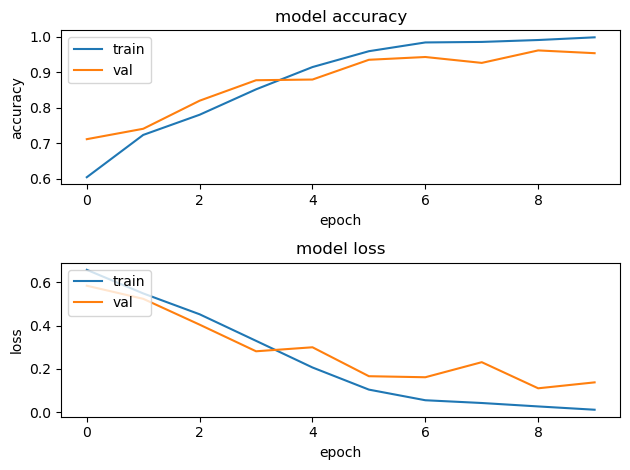

In [15]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
kfold = KFold(n_splits=5, shuffle=True)

In [17]:
acc_per_fold = []
loss_per_fold = []
Y_preds = []
Y_actuals = []

In [18]:
fold_no = 1
num_classes = 2

for train, test in kfold.split(X,Y):

    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_classes)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X[train], Y[train],
                        batch_size=32,
                        epochs=10,
                        verbose=1)
    # Generate generalization metrics
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    for x in Y[test]:
        Y_actuals = np.append(Y_actuals, x)
    for z in model.predict(X[test]):
        Y_preds = np.append(Y_preds, np.argmax(z))
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
160/160 [==============================] - 77s 475ms/step - loss: 0.6533 - accuracy: 0.6299
Epoch 2/10
160/160 [==============================] - 76s 476ms/step - loss: 0.5158 - accuracy: 0.7451
Epoch 3/10
160/160 [==============================] - 79s 493ms/step - loss: 0.3464 - accuracy: 0.8471
Epoch 4/10
160/160 [==============================] - 81s 506ms/step - loss: 0.1844 - accuracy: 0.9338
Epoch 5/10
160/160 [==============================] - 80s 500ms/step - loss: 0.0915 - accuracy: 0.9650
Epoch 6/10
160/160 [==============================] - 81s 508ms/step - loss: 0.0526 - accuracy: 0.9824
Epoch 7/10
160/160 [==============================] - 76s 477ms/step - loss: 0.0373 - accuracy: 0.9865
Epoch 8/10
160/160 [==============================] - 80s 502ms/step - loss: 0.0089 - accuracy: 0.9982
Epoch 9/10
160/160 [==============================] - 79s 493ms/step - loss: 0.

In [19]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, 5):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08750960230827332 - Accuracy: 98.046875%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.07459420710802078 - Accuracy: 97.5781261920929%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.14925989508628845 - Accuracy: 95.703125%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.06492125242948532 - Accuracy: 97.50000238418579%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.05299310013651848 - Accuracy: 98.3593761920929%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.43750095367432 (+- 0.922272467194441)
> Loss: 0.08585561141371727
-----------------------------------------

In [20]:
Y_actuals.size

6400

In [21]:
Y_preds.size

6400

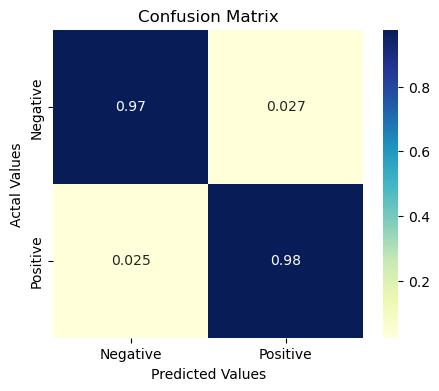

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(Y_actuals, Y_preds, normalize = "true")
cm_df = pd.DataFrame(cm,
index = ['Negative','Positive'],
columns = ['Negative','Positive'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('myCNN2')

In [33]:
FP = 0.027
FN = 0.025
TP = 0.98
TN = 0.97

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall: ")
print(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity: ")
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Presicion: ")
print(TNR)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall Out: ")
print(FPR)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

Total = FP+FN+TP+TN

# Overall accuracy
ACC = (TP+TN)/Total
print("Accuracy: ")
print(ACC)

# Random accuracy
R_ACC = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP))/(Total*Total)

# Kappa
KAPPA = (ACC-R_ACC)/(1-R_ACC)
print("Kappa: ")
print(KAPPA)

F1 = 2 * (TNR * TPR) / (TNR + TPR)
print("F1:")
print(F1)

Recall: 
0.9751243781094528
Specificity: 
0.9729187562688064
Presicion: 
0.9729187562688064
Fall Out: 
0.02708124373119358
Accuracy: 
0.9740259740259741
Kappa: 
0.9480507037586693
F1:
0.9740203185597697
